# Домашнее задание №9
    1) Постройте графики, визуализирующие каждый временной ряд. Охарактеризуйте временные ряды, присутствуют ли в них тренд, сезонность или цикл?
    2) Преобразуйте временные ряды к стационарному виду. Обоснуйте и опишите методы, которые Вы использовали. Приведите графики и результаты статистических тестов, подтверждающих, что ряд стал стационарным.
    3) Постройте и опишите коррелограммы (графики автокорреляционной функции и частной автокорреляционной функции) для 2-х временных рядов.
    4) По каждому временному ряду разбейте выборку на обучающую и тестовую (обоснуйте выбор временного интервала для тестовой выборки). На основе обучающей выборки идентифицируйте параметры модели АРПСС (ARIMA) Какие параметры модели p, d и q Вы будете использовать и почему? Оцените качество модели. Насколько хорошо она предсказывает значения тестовой выборки?
    5) Используя модель ARIMA, постройте прогноз 2-х временных рядов на 3 года вперёд от даты окончания временного диапазона (например, если у Вас временной диапазон 12.12.2013–29.12.2017, то до 29.12.2020, если у Вас временной диапазон 02.10.2017 – 17.11.2022, то до 17.11.2025), приведите их графики.
    6) Проверьте с помощью соответствующих критериев адекватность (независимость и нормальность распределения остатков) каждой прогнозной модели для 2-х временных рядов, оцените качество прогнозной модели.    

В данной работе мы будем прогнозировать количество продаж на 4 месяца, по имеющимся данным за 2010 - 2020 гг.

Также, в данной работе, мы чаще будем использовать библиотеку plotly, нежели plot, так как она интерактивная и позволяет отлеживать конкретные значения при наведении.

## Чтение и предварительная обработка данных

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("soldInfo.csv")
df = df.drop(columns=['Unnamed: 0']) # Удаляем ненужную колонку

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255640 entries, 0 to 255639
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         255640 non-null  object
 1   store        255640 non-null  int64 
 2   product      255640 non-null  int64 
 3   number_sold  255640 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ MB


Пропущенных значений в датасете нет, что позволяет нам работать с ним без запонления пропусков

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # Изменим тип данных в столбце Date на datetime вместо object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255640 entries, 0 to 255639
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Date         255640 non-null  datetime64[ns]
 1   store        255640 non-null  int64         
 2   product      255640 non-null  int64         
 3   number_sold  255640 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.8 MB


In [ ]:
# Т.к. данных было слишком много, мы приняли решение получить ежемесячные данные, вместо ежедневных
df['YearMonth'] = df['Date'].dt.to_period('M') # Создали новую колонку, в которой информация по месяцу и году
df_result = df.groupby(df['Date'].dt.to_period('M')).agg({'number_sold': 'sum'}) # Сгруппировали по месяцу-году, получив суммарные значения количества продаж по всем магазинам
df_result.index.name = 'YearMonth' # Обновили индексы
df_result.index = df_result.index.to_timestamp() # Изменили типа данных у индексов

In [6]:
df_result

,number_sold
YearMonth,
2010-01-01,1698403
2010-02-01,1529750
2010-03-01,1688388
2010-04-01,1630998
2010-05-01,1685240
...,...
2019-08-01,1717806
2019-09-01,1667298
2019-10-01,1725393


## Задание 1. Постройте графики, визуализирующие каждый временной ряд. Охарактеризуйте временные ряды, присутствуют ли в них тренд, сезонность или цикл?

In [92]:
fig = px.line(
    df_result, 
    x=df_result.index, 
    y=df_result['number_sold'], 
    labels={'Date': 'Период', 'number_sold': 'Количество продаж'}, 
    title='Продажи по месяцам'
)

fig.update_layout(
    xaxis=dict(title='Период', tickformat='%Y'),
    yaxis=dict(title='Количество продаж'),
    template='plotly_white'
)

fig.show()

По полученному графику можно отметить следующее:
1) Виден слабо выраженный тренд роста общего количества продаж со временем (хотя изменения минимальны). 
2) Наблюдается чёткая сезонность - видны регулярные пики и спады в одно и то же время года, что говорит о периодичности продаж в течение года.

In [88]:
decomposition = seasonal_decompose(df_result, model='additive')

# Извлечение компонентов тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = make_subplots(
    rows=4, cols=1, 
    shared_xaxes=True,
    subplot_titles=[
        'Исходный временной ряд',
        'Компонент тренда',
        'Компонент сезонности',
        'Остаточные компоненты'
    ]
)

# График исходного временного ряда
fig.add_trace(
    go.Scatter(x=df_result.index, y=df_result['number_sold'], mode='lines', name='Исходный ряд'),
    row=1, col=1
)

# График компонента тренда
fig.add_trace(
    go.Scatter(x=df_result.index, y=trend, mode='lines', name='Тренд'),
    row=2, col=1
)

# График компонента сезонности
fig.add_trace(
    go.Scatter(x=df_result.index, y=seasonal, mode='lines', name='Сезонность'),
    row=3, col=1
)

# График остаточных компонентов
fig.add_trace(
    go.Scatter(x=df_result.index, y=residual, mode='lines', name='Остатки'),
    row=4, col=1
)

fig.update_layout(
    height=1400, 
    width=1700
)

fig.show()


По полученным графикам можно сделать следующие выводы:
1. Исходный временной ряд. Мы его рассмотрели немного ранее, однако, стоит отметить, что график показывает общее количество ежемесячных продаж за период с 2010 по 2020 годы. Видна четкая сезонность — регулярные спады повторяются ежегодно в феврале (можно предположить, что это связано с окончанием новогодних праздников и "снижением количества денег" после праздников)

2. Компонент тренда. Тренд показывает долгосрочное изменение среднего уровня ряда. Можно отметить, что с 2010 по 2015 год тренд был практически стабильным с незначительным снижением в середине периода.
Начиная с 2015 года, наблюдается устойчивый рост тренда, который особенно заметен ближе к 2020 году.

3. Компонент сезонности. Сезонность показывает циклические колебания ряда с постоянным периодом. Мы видим, что каждый год наблюдаются одинаковые циклические паттерны. Каждый февраль наблюдаются спады количества продаж, о чем мы говорили чуть выше.

4. Остаточные компоненты. Остаточные компоненты представляют собой случайные колебания. Как мы видим, большинство остаточных компонент незначительны, но в некоторые моменты (например, в феврале 2012 года или 2016 года) наблюдаются резкие скачки. 

Источники: 

[Лекция 10 "Анализ временных рядов", преподаватель: Меликян А.В.]

[https://www.geeksforgeeks.org/seasonal-adjustment-and-differencing-in-time-series/]

In [93]:
fig = go.Figure()

# Исходный временной ряд
fig.add_trace(
    go.Scatter(
        x=df_result.index,
        y=df_result['number_sold'],
        mode='lines',
        name='Исходные данные',
        line=dict(color='blue')
    )
)

# Скользящее среднее за 6 месяцев
rolling_mean = df_result.rolling(6).mean()
fig.add_trace(
    go.Scatter(
        x=df_result.index,
        y=rolling_mean['number_sold'],
        mode='lines',
        name='Скользящее среднее (6 месяцев)',
        line=dict(color='red')
    )
)

# Скользящее стандартное отклонение за 6 месяцев
rolling_std = df_result.rolling(6).std()
fig.add_trace(
    go.Scatter(
        x=df_result.index,
        y=rolling_std['number_sold'],
        mode='lines',
        name='Скользящее стандартное отклонение (6 месяцев)',
        line=dict(color='black')
    )
)

fig.update_layout(
    title='Исходные данные, скользящее среднее и стандартное отклонение (6 месяцев)',
    xaxis_title='Период',
    yaxis_title='Количество продаж',
    height=700,
    width=1700
)

fig.show()


По данному графику можно сказать следующее:
1. Скользящее среднее (красная линия). Скользящее среднее - это широко используемый метод анализа временных рядов. Он позволяет сгладить случайные краткосрочные колебания и выявить более долгосрочные тенденции в данных. Красная линия схожа с с исзодными данными (по силуэту линии), но не сильно совпадает с ними. На протяжении всего периода скользящее среднее остается почти горизонтальным, без явных долгосрочных изменений.
2. Скользящее стандартное отклонение (черная линия). По всей видимости это отклонение между скользящим средними и реальными значениями. Как мы видим линия находится близко к нулю, что говорит о низкой изменчивости данных, получается, что сезонные колебания данных почти не влияют на величину стандартного отклонения.

Источник: [https://teletype.in/@pythontalk/time_series_forecasting#irIQ]

## Задание 2. Преобразуйте временные ряды к стационарному виду. Обоснуйте и опишите методы, которые Вы использовали. Приведите графики и результаты статистических тестов, подтверждающих, что ряд стал стационарным. 

### Тест Дики — Фуллера на стационарность

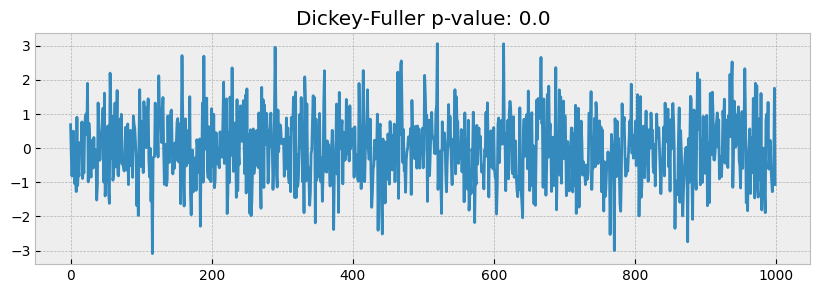

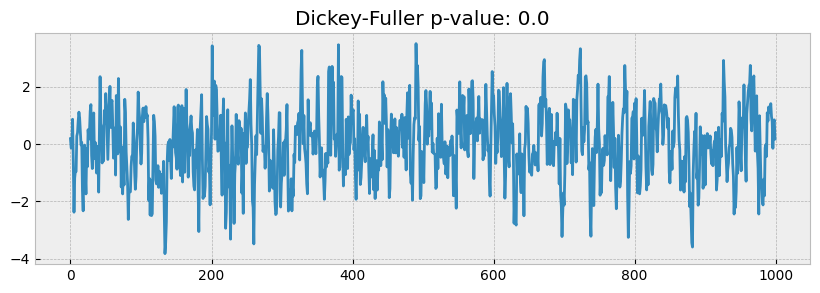

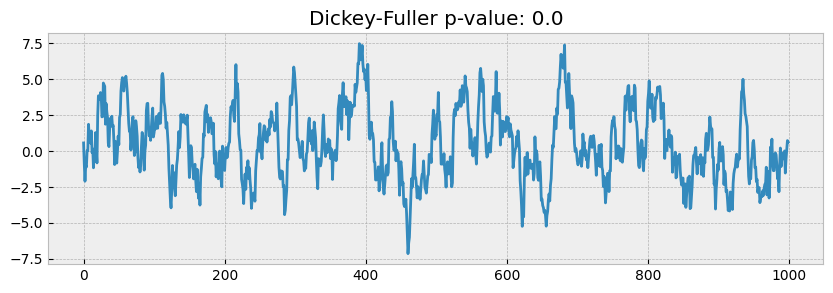

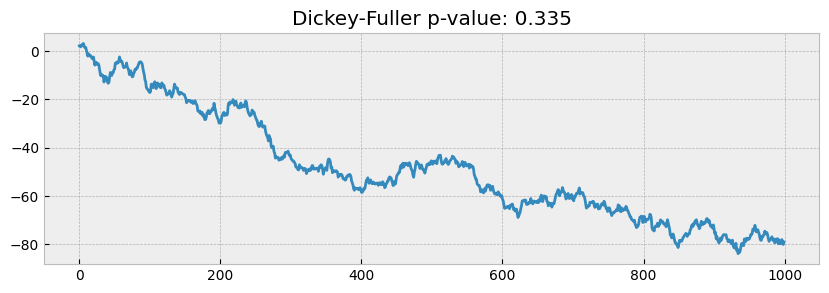

In [12]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(x)[1], 3)))
        plt.show()
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

Тест Дики-Фуллера - это распространённый в статистике тест, который используется для проверки того, является ли временной ряд статиционарныс. Данный временной ряд можно назвать стационарны, если он не имеет тенденции, демонстрирует постоянную дисперсию во времени и постоянно следует структуре автокорреляции.

Задействованы следующие гипотезы:

H0: Временной ряд считается нестационарным. Проще говоря, можно сказать, что он в некоторой степени зависит от времени и не имеет постоянной дисперсии в течение определённого периода времени.
H1: Временной ряд считается стационарным.
Теперь, если значение p в результате этого теста окажется меньше определённого уровня (например, p-val = 0,05), то в таких случаях мы можем отвергнуть нулевую гипотезу и прийти к выводу, что временной ряд является стационарным.

Источник: [https://www.geeksforgeeks.org/how-to-perform-an-augmented-dickey-fuller-test-in-r/]

Рассмотрим, что же у нас получилось на графиках:

1. При rho = 0 значение p-value = 0.0, что подтверждает стационарность (нет тренда или зависимости во времени). Визуально ряд выглядит как равномерно распределенный шум.
2. При rho = 0.6 значение p-value = 0.0, ряд начинает показывать небольшие тренды, но все еще остаётся стационарным. Визуально видна некоторая сглаженность, но нет долговременного тренда.
3. При rho = 0.9 значение  p-value = 0.0, ряд показывает продолжительные отклонения от среднего значения (более выраженные волны), но ряд всё ещё стационарен, хотя визуально кажется менее стабильным.
4. При rho = 1 значение p-value = 0.776, ряд показывает долгосрочные тренды, отклонения не возвращаются к среднему значению. Полученное p-value указывает на нестационарность.  

In [13]:
from statsmodels.tsa.stattools import adfuller #Тест Дики — Фуллера на стационарность 
adft = adfuller(df_result)
print('p-value: ', adft[1])
#Если p-value<0.05, то ряд стационарный

p-value:  0.9981181716492366


Вывод: ряд не является стационарным. Это закономерно, поскольку в нём присутствуют явный тренд и сезонность.

In [95]:
df_result['number_sold_dif1'] = df_result['number_sold'] - df_result['number_sold'].shift(1) #один раз дифференцируем ряд
adft = adfuller(df_result['number_sold_dif1'].dropna(),autolag="AIC")
print('p-value: ', adft[1])

p-value:  0.0


Однократно дифференцированный ряд стал стационарным на 5% уровне значимости.

In [97]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_result.index,
        y=df_result['number_sold'],
        mode='lines',
        name='Исходные данные',
        line=dict(color='blue')
    )
)

# Одна дифференциация
fig.add_trace(
    go.Scatter(
        x=df_result.index,
        y=df_result['number_sold_dif1'],
        mode='lines',
        name='Одна дифференциация',
        line=dict(color='red')
    )
)

fig.update_layout(
    title='Исходные данные и одна дифференциация',
    xaxis_title='Период',
    yaxis_title='Количество продаж',
    legend=dict(orientation='h', y=-0.2),  # Легенда внизу
    template='plotly_white',
    height=500,
    width=1700
)

# Показать график
fig.show()


После первого дифференцирования ряд стал стационарным, так как убраны долгосрочные тренды.
Как мы видим по графику, имеется оставшаяся сезонность, но колебания теперь сосредоточены вокруг среднего значения (около 0).

## Задание 3. Постройте и опишите коррелограммы (графики автокорреляционной функции и частной автокорреляционной функции) для 2-х временных рядов.

In [16]:
for i in range(1, 25): # пройдем циклом по автокорреляциям от 1 до 24 месяцев
    autocorrelation_lag = df_result['number_sold'].autocorr(lag=i)
    print(f"{i} Month Lag: ", autocorrelation_lag)

1 Month Lag:  -0.3693904546914574
2 Month Lag:  0.18826417535491247
3 Month Lag:  0.006300711107160797
4 Month Lag:  -0.0944285108975292
5 Month Lag:  0.1896013321249899
6 Month Lag:  -0.4694281605000962
7 Month Lag:  0.217022124026988
8 Month Lag:  -0.15096421826788706
9 Month Lag:  0.0357866691977711
10 Month Lag:  0.1209627587386069
11 Month Lag:  -0.3558925630599862
12 Month Lag:  0.972842827128432
13 Month Lag:  -0.3808707494403701
14 Month Lag:  0.1875970979527129
15 Month Lag:  -0.0022654051131924826
16 Month Lag:  -0.10124309154976961
17 Month Lag:  0.18412968967493548
18 Month Lag:  -0.4807417996735726
19 Month Lag:  0.21455658741573888
20 Month Lag:  -0.16300918740368808
21 Month Lag:  0.03210889937291633
22 Month Lag:  0.11273980058846306
23 Month Lag:  -0.36404594562860904
24 Month Lag:  0.9654354670296319


По полученным значениямможно сказать, например, что значение автокорреляции с лагом 1 = -0.37 указывает на обратную зависимость между значениям временного ряда и его значениям месяцем ранее. Это значит, что если в текущем месяце значение ряда увеличивается, то в следующем месяце оно с высокой вероятностью уменьшается.
А вот значение автокорреляции с лагом 12 и 24 очень близки к единице - это свидетельствует о сезонности в данных, что ежегодно значения рядаимеют схожие тенденции

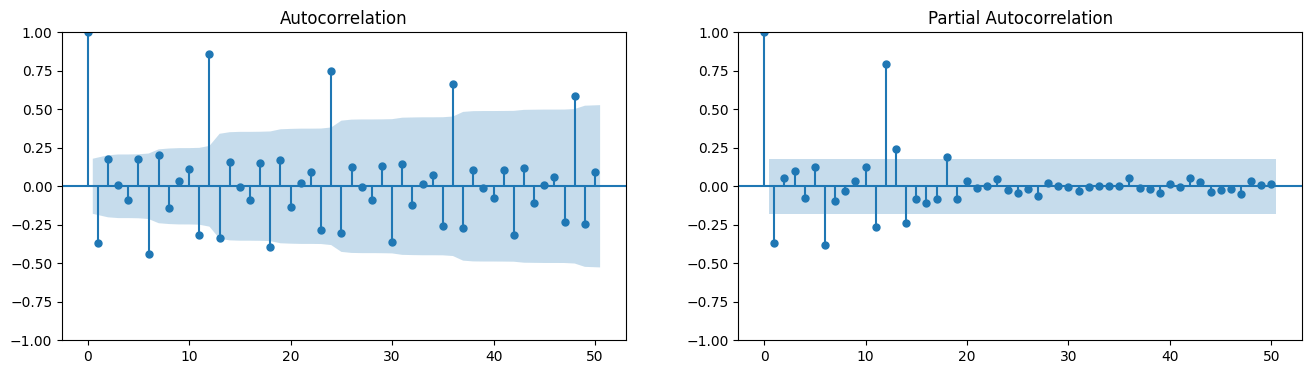

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,4), dpi= 100)
plot_acf(df_result['number_sold'], lags=50, ax=axes[0])
plot_pacf(df_result['number_sold'], lags=50, ax=axes[1])
plt.show()

По полученным графикам можно отметить следующее:
1. График Autocorrelation. Этот график показывает степень автокорреляции временного ряда на лагах от 1 до 50. Голубая область — это доверительный интервал. Если точки находятся внутри интервала, автокорреляция считается статистически незначимой.
На первом лаге видна отрицательная корреляция (примерно -0.37), что согласуется с ранее рассчитанным значением автокорреляции.
Сильная положительная корреляция наблюдается на лагах, кратных 12 (например, 12, 24, 36), что свидетельствует о сезонности в данных (период 12 месяцев) - как мы и отмечали ранее.

2. График Partial Autocorrelation. График PACF показывают связь между текущим значением ряда и его значениями на определенном лаге, исключая влияние промежуточных лагов. 
Лаг 1 имеет умеренно отрицательное значение (подтверждая обратную зависимость с предыдущими значениями).
На лаге 12 также видна сильная положительная корреляция, что подтверждает сезоннность (период = 12).
После 12 лага корреляция становится статистически незначимой (штрихи внутри голубого интервала), что говорит о том, что дальние лаги не имеют значимой связи.

Источники:

[https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb]

[https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14]

## Задание 4. По каждому временному ряду разбейте выборку на обучающую и тестовую (обоснуйте выбор временного интервала для тестовой выборки). На основе обучающей выборки идентифицируйте параметры модели АРПСС (ARIMA) Какие параметры модели p, d и q Вы будете использовать и почему? Оцените качество модели. Насколько хорошо она предсказывает значения тестовой выборки?

Обучающая выборка: данные за с января 2010 года по август 2019 гг. включительно

Тестовая выборка: данные за сентябрь - декабрь 2019 г.

In [63]:
split_date = '2019-09-01'

train = df_result[df_result.index < split_date]
train = train.drop(columns=["number_sold_dif1"])

test = df_result[df_result.index >= split_date]
test = test.drop(columns=["number_sold_dif1"])

In [101]:
fig = go.Figure()

# Обучающая выборка (Train)
fig.add_trace(
    go.Scatter(
        x=train.index,
        y=train['number_sold'],
        mode='lines',
        name='Обучающая выборка',
        line=dict(color='black')
    )
)

# Тестовая выборка (Test)
fig.add_trace(
    go.Scatter(
        x=test.index,
        y=test['number_sold'],
        mode='lines',
        name='Тестовая выборка',
        line=dict(color='red')
    )
)

fig.update_layout(
    title='Обучающая и тестовая выборки по данным о количестве продаж',
    xaxis_title='Период',
    yaxis_title='Количество продаж',
    height=500,
    width=1700
)

fig.show()


В дальнейшем мы будем предсказывать значения количества продаж за последние 4 месяца 2019 года, учитывая, что мы знаем реальные значения.

## Задание 5. Используя модель ARIMA, постройте прогноз 2-х временных рядов на 3 года вперёд от даты окончания временного диапазона (например, если у Вас временной диапазон 12.12.2013–29.12.2017, то до 29.12.2020, если у Вас временной диапазон 02.10.2017 – 17.11.2022, то до 17.11.2025), приведите их графики.

### <b> Так как у нас небольшой датасет, то мы спрогнозируем данные не на 3 года вперед, а на 4 месяца. </b>

### ARIMA

In [66]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=4)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2819.355, Time=1.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2830.016, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2813.660, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2816.640, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3654.692, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2815.832, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2816.204, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2817.829, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.228 seconds


Наилучшей моделью получилась модель ARIMA (ARIMA - это модель ARMA c p авторегрессионными лагами, q лагами скользящего среднего и дифференциацией порядка d.) p = 1, d = 0, q = 0, т.к. у нее самое низкое значение критерия Акаике.
Выбранные значения указывают, что наилучшая модель имеет следующие параметры:

- Количество авторегрессионными лагов = 1.
- Дифференциация нулевого порядка.
- Количество лагов скользящего среднего = 0.

In [102]:
fig = go.Figure()

# Обучающая выборка (Train)
fig.add_trace(
    go.Scatter(
        x=train.index,
        y=train['number_sold'],
        mode='lines',
        name='Train',
        line=dict(color='blue')
    )
)

# Тестовая выборка (Test)
fig.add_trace(
    go.Scatter(
        x=test.index,
        y=test['number_sold'],
        mode='lines',
        name='Test',
        line=dict(color='orange')
    )
)

# Прогноз (Forecast)
fig.add_trace(
    go.Scatter(
        x=forecast.index,
        y=forecast['Prediction'],
        mode='lines',
        name='Prediction',
        line=dict(color='green')
    )
)

fig.update_layout(
    title='Предсказанное количество продаж',
    xaxis_title='Период',
    yaxis_title='Количество продаж',
    height=500,
    width=1700
)

# Показ графика
fig.show()


Как мы видим, предсказанное количество продаж не точно совпадает с реальными продажами (например, фактическое значение в сентябре 2019 года = 1 667 298 продаж, а предсказанное значение на сентябрь 2019 года = 1 643 642 продаж). Однако, мы можем заметить, что предсказанные значения сохраняют динамику, схожую, с реальной картиной.

In [103]:
df_result.index = pd.DatetimeIndex(df_result.index.values, freq=df_result.index.inferred_freq)

In [107]:
from statsmodels.tsa.arima.model import ARIMA
model  =  ARIMA(df_result['number_sold'], order=(1, 0, 0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                  120
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1452.654
Date:                Sun, 01 Dec 2024   AIC                           2911.308
Time:                        21:53:39   BIC                           2919.671
Sample:                    01-01-2010   HQIC                          2914.704
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.666e+06   3529.060    471.960      0.000    1.66e+06    1.67e+06
ar.L1         -0.3694      0.126     -2.931      0.003      -0.617      -0.122
sigma2      1.921e+09      0.030   6.43e+10      0.0

Рассмотрим полученные коэффициенты модели:

Все переменные в модели (const, ar.L1 и sigma2) являются статистически значимыми, так как их p-value < 0.05.

- const = 1.666e+06. Это константа модели, которая соответствует среднему значению ряда. Значение большое, так как значения количества прадаж по исходным данным тоже большое.
- ar.L1 = -0.3694. Коэффициент авторегрессии на лаге 1. Это означает, что текущее значение ряда связано с предыдущим значением с обратной зависимостью (отрицательная корреляция), что согласуется с ранее рассчитанным значением автокорреляции на лаге 1.
- sigma2 = 1.921e+09. Это дисперсия остатков модели, она имеет высокое значение, что также связано с высокими значениями в данных о количестве продаж, в целом.

## Задание 6 Проверьте с помощью соответствующих критериев адекватность (независимость и нормальность распределения остатков) каждой прогнозной модели для 2-х временных рядов, оцените качество прогнозной модели.   

In [108]:
from sklearn.metrics import mean_squared_error

predictions = res.predict(start=test.index[0], end=test.index[-1])
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error: {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 2193093300.092589
Root Mean Squared Error: 46830.47405368206


Как мы видим среднеквадратическая ошибка равна примерно 46 830 единиц (в нашем случае продаж).
Среднеквадратическая ошибка — это способ измерения средней величины различий между прогнозируемыми значениями и фактическими значениями. По сути, она количественно определяет, насколько хорошо модель прогнозирует числовые результаты.

Получается, что, в среднем, предсказанное значение отклоняется от фактического на 46830 продаж. Учитывая, что среднее количество продаж в месяц составляет более 1,5 млн., то это не такой уж и плохой результат.

Источник: [https://www.geeksforgeeks.org/step-by-step-guide-to-calculating-rmse-using-scikit-learn/]

In [120]:
residuals = pd.DataFrame(res.resid)
residuals.index = pd.to_datetime(residuals.index)

# Создаем график остатков
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=residuals.index,
        y=residuals[0],
        mode='lines',
        name='Residuals',
        line=dict(color='blue')
    )
)

fig.update_layout(
    title='Остатки модели',
    xaxis_title='Период',
    yaxis_title='Остатки',
    height=500,
    width=1700
)

fig.show()

По графику визуализации остатков можно отметить, что чётко видна сезонность, которая. к сожалению, не учлась моделью. Это означает, что ARIMA(1, 0, 0) недостаточно хорошо описывает данные.
Также. на графике видны резкие спады, что указывает "недооценённость" реальных значений моделью.

Мы предполагаем, что если у нас было бы больше данных (за большее количество лет), то модель могла бы лучше прогнозировать результаты.

<Axes: ylabel='Density'>

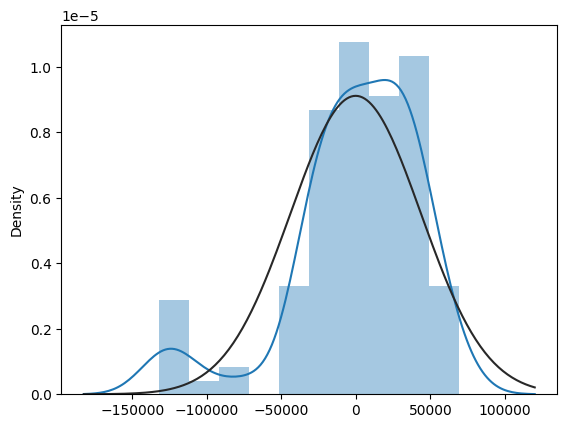

In [116]:
from scipy import stats 
sns.distplot(residuals, fit=stats.norm) 

По графику распределния остатков можно сказать следующее:

- Центр распределения близок к нулю, но симметрия нарушена (хвосты с двух сторон неоднородны);
- Синяя кривая отклоняется от чёрной кривой, которая отображает нормальное распределение, что говорит о несоответствии остатков нормальному распределению;
- Видны заметные выбросы в отрицательном диапазоне (около -150000).

In [118]:
from scipy import stats 
p = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std())).pvalue
print('P-value: {:.3f}'.format(p[0]))

P-value: 0.025


Результаты теста Колмогорова-Смирнова также указывают на то, что распределение остаток отличается от нормального распределения (исходя из низкого p-value).

## Общий вывод

В данной работе мы прогнозировали количество продаж на 4 месяца, с учетом имеющихся данных о количестве продаж за 10 лет (с 2010 по 2020 гг.)

В исходном временном ряде наблюдается четкая сезонность — регулярные спады повторяются ежегодно в феврале (можно предположить, что это связано с окончанием новогодних праздников и "снижением количества денег" после праздников)

Для прогнозирования значений была выбрана модель ARIMA со следующими параметрами:
- p=1 - модель включает авторегрессионный компонент с одним лагом;
- d=0 - модель не включает дифференцирование, так как данные предположительно стационарны;
- q=0 - модель не использует компонент скользящего среднего.

У полученной модели все предикторы являются статистически значимыми. 
Среднеквадратическая ошибка полученной модели равна примерно 46 830 продаж). Учитывая, что среднее количество продаж в месяц составляет более 1,5 млн., то это не такой уж и плохой результат.

По остаткам видно, что модель плохо учла сезонность в данных, и распределение остатков отличается от нормального.

По нашим предположениям, если бы было больше данных (за большее количество лет), то модель получилась бы более точной.

P.S. пока писали вывод подумали, что подобную модель можно использовать для составления плана по продажам для сотрудников на ближайшие месяцы, исходя из которого будет формироваться их премия. Однако, чтобы это реализовать на практике, нужна более хорошая модель.
